# 2.3.1-2.3.3 ユーザ行動モデルの出現割合を変化させたときの推定量の挙動
参考文献
- Haruka Kiyohara, Masatoshi Uehara, Yusuke Narita, Nobuyuki Shimizu, Yasuo Yamamoto, and Yuta Saito. [Off-Policy Evaluation of Ranking Policies under Diverse User Behavior](https://arxiv.org/abs/2306.15098). KDD2023.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_ips, calc_iips, calc_rips, calc_aips
from utils import eps_greedy_policy, aggregate_simulation_results

### 独立モデルよりも複雑な行動モデルを持つユーザの割合を変化させたときのIPS・IIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [2]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 3000 # ログデータのサイズ
num_actions = 4 # ユニークなアイテム数
K = 6 # ランキングの長さ
beta = 1 # データ収集方策のパラメータ
random_state = 12345
p_complex_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] # 独立性よりも複雑な行動モデルを持つユーザの割合

In [3]:
result_df_list = []
for p_complex in p_complex_list:
    ## 評価方策の真の性能(policy value)を計算
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))
    p = [1 - p_complex, p_complex / 2, p_complex / 2]
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, K=K, p=p,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"p_complex={p_complex}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_values["iips"] = calc_iips(offline_logged_data, pi)
        estimated_policy_values["rips"] = calc_rips(offline_logged_data, pi)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "p_complex", p_complex,
        )
    )
result_df_ind = pd.concat(result_df_list).reset_index(level=0)


p_complex=1.0...: 100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


## 図2.14

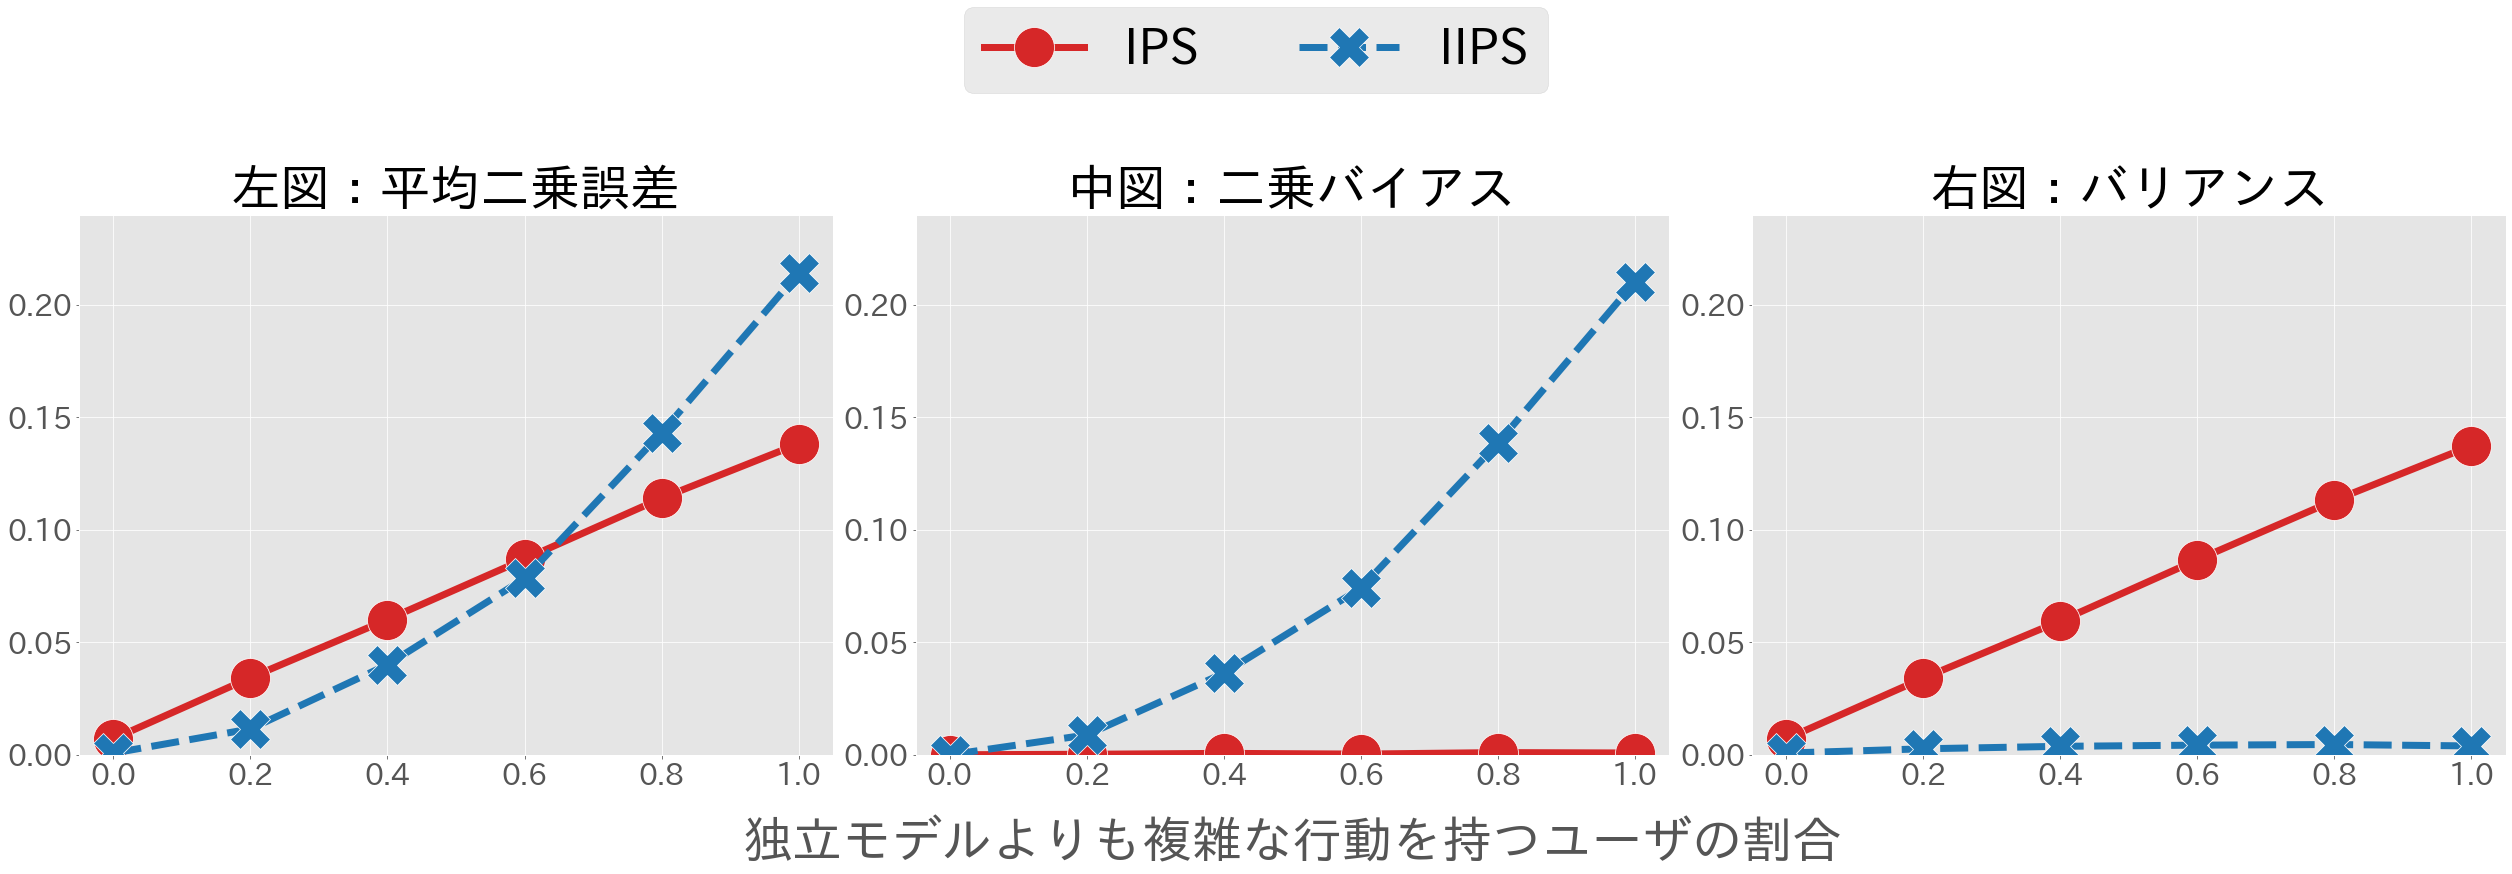

In [4]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="p_complex",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:blue"],
        data=result_df_ind.query("est != 'avg' and est != 'aips' and est != 'rips'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.24)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if y == "bias":
        ax.set_xlabel(r"独立モデルよりも複雑な行動を持つユーザの割合", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=40)
    ax.set_xticks(p_complex_list)
    ax.set_xticklabels(p_complex_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "IIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


### カスケードモデルよりも複雑な行動モデルを持つユーザの割合を変化させたときのIPS・IIPS・RIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [5]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 3000 # ログデータのサイズ
num_actions = 4 # ユニークなアイテム数
K = 6 # ランキングの長さ
beta = 1 # データ収集方策のパラメータ
random_state = 12345
p_complex_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] # カスケード性よりも複雑な行動モデルを持つユーザの割合

In [6]:
result_df_list = []
for p_complex in p_complex_list:
    ## 評価方策の真の性能(policy value)を計算
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))
    p = [0, 1 - p_complex, p_complex]
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, K=K, p=p,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"p_complex={p_complex}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data, pi)
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_values["iips"] = calc_iips(offline_logged_data, pi)
        estimated_policy_values["rips"] = calc_rips(offline_logged_data, pi)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "p_complex", p_complex,
        )
    )
result_df_cascade = pd.concat(result_df_list).reset_index(level=0)


p_complex=1.0...: 100%|██████████| 1000/1000 [01:25<00:00, 11.67it/s]


## 図2.21

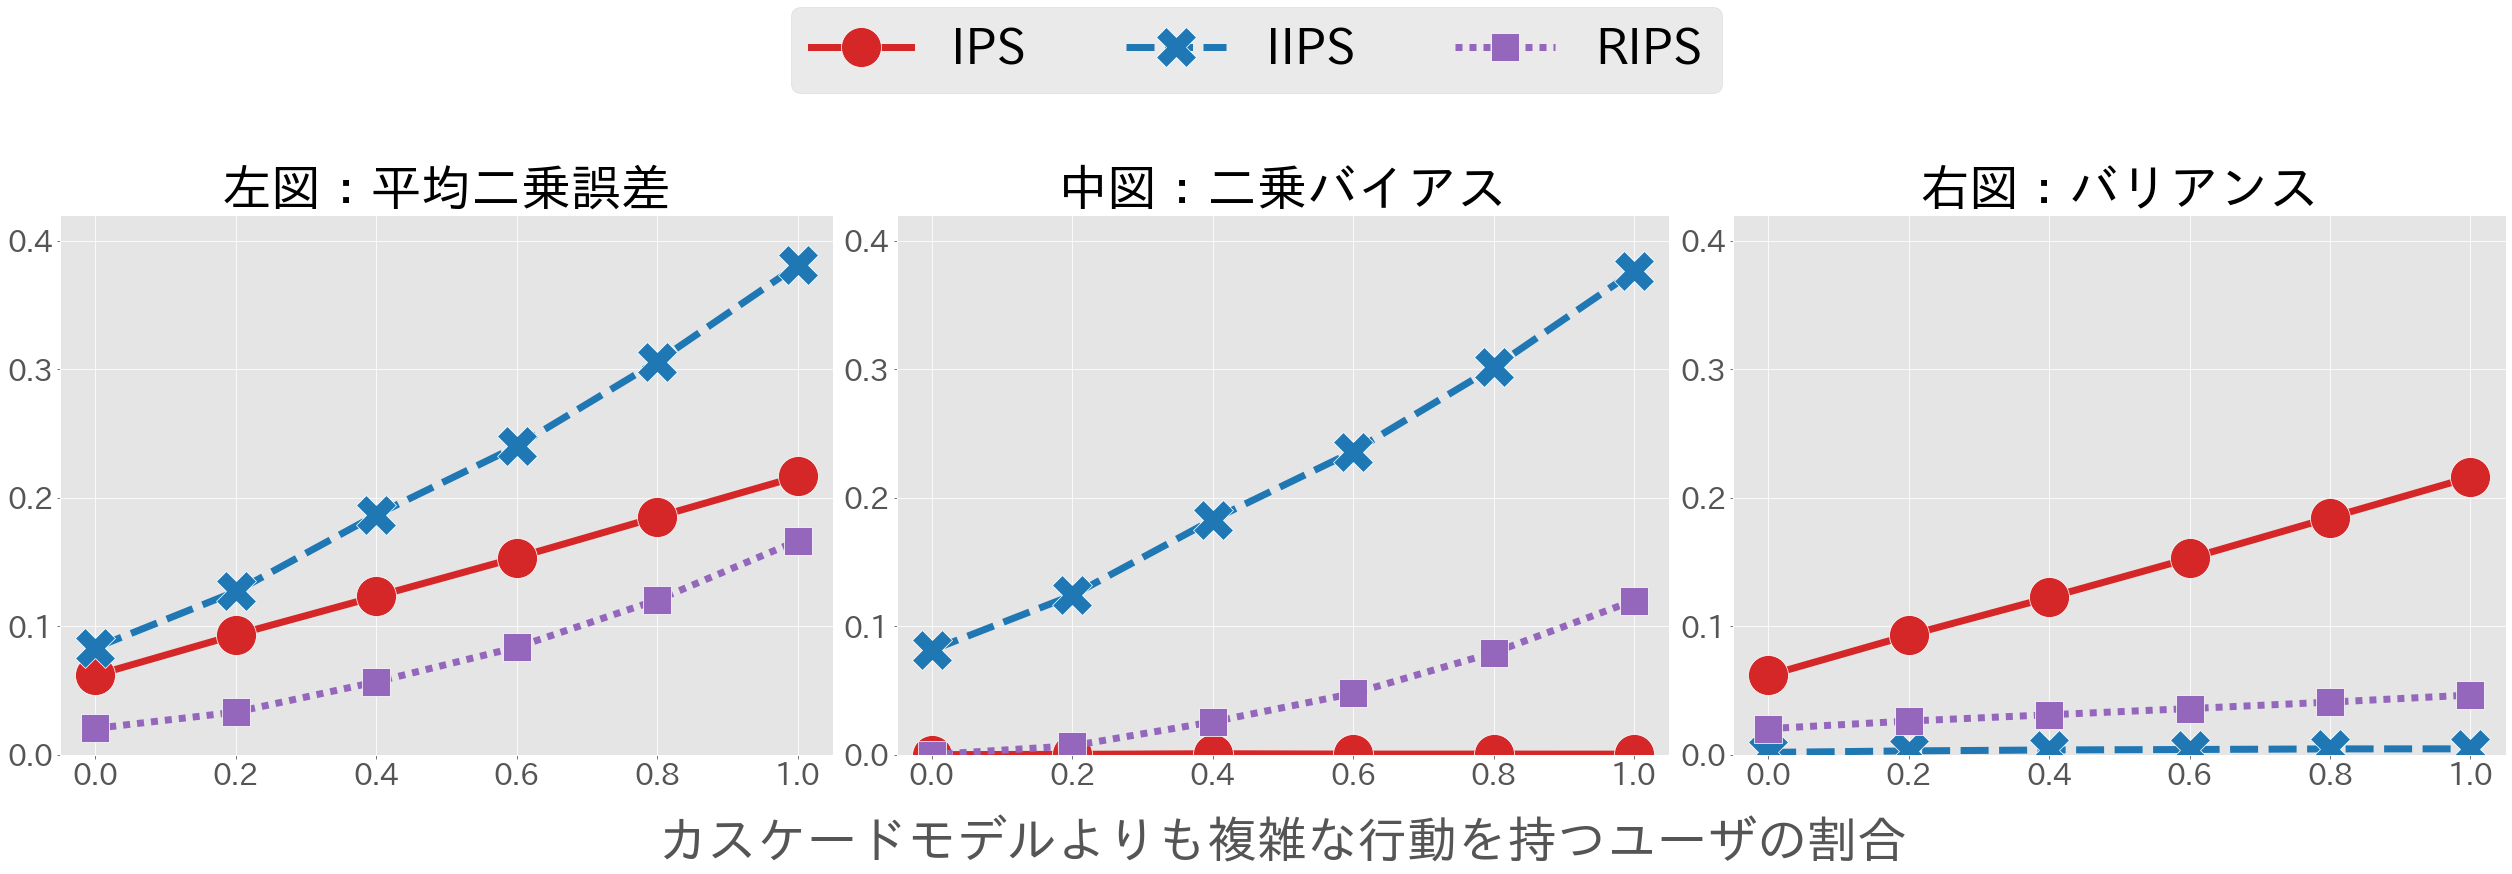

In [7]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="p_complex",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:blue", "tab:purple"],
        data=result_df_cascade.query("est != 'avg' and est != 'aips'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.42)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if y == "bias":
        ax.set_xlabel("カスケードモデルよりも複雑な行動を持つユーザの割合", fontsize=50)
    else:
        ax.set_xlabel("", fontsize=40)
    ax.set_xticks(p_complex_list)
    ax.set_xticklabels(p_complex_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["IPS", "IIPS", "RIPS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


### 複雑な行動モデルを持つユーザの割合を変化させたときのAIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [8]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 2000 # ログデータのサイズ
num_actions = 4 # ユニークなアイテム数
K = 8 # ランキングの長さ
beta = 1 # データ収集方策のパラメータ
p = [0.7, 0.2, 0.1] # ユーザ行動の出現割合
random_state = 12345
p_rand_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] # 独立モデル, カスケードモデル以外のユーザ行動の出現割合
max_k_dict = {0.0: 3, 0.2: 4, 0.4: 5, 0.6: 5, 0.8: 6, 1.0: 6}


In [9]:
result_df_list = []
for p_rand in p_rand_list:
    ## 評価方策の真の性能(policy value)を計算
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, K=K, p=p, p_rand=p_rand,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"p_rand={p_rand}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, p_rand=p_rand, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["aips"] = calc_aips(offline_logged_data, pi)
        estimated_policy_values["aips (tune)"] = calc_aips(offline_logged_data, pi, max_k=max_k_dict[p_rand])
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "p_rand", p_rand,
        )
    )
result_df_rand = pd.concat(result_df_list).reset_index(level=0)

p_rand=1.0...: 100%|██████████| 1000/1000 [01:07<00:00, 14.89it/s]


## 図2.26

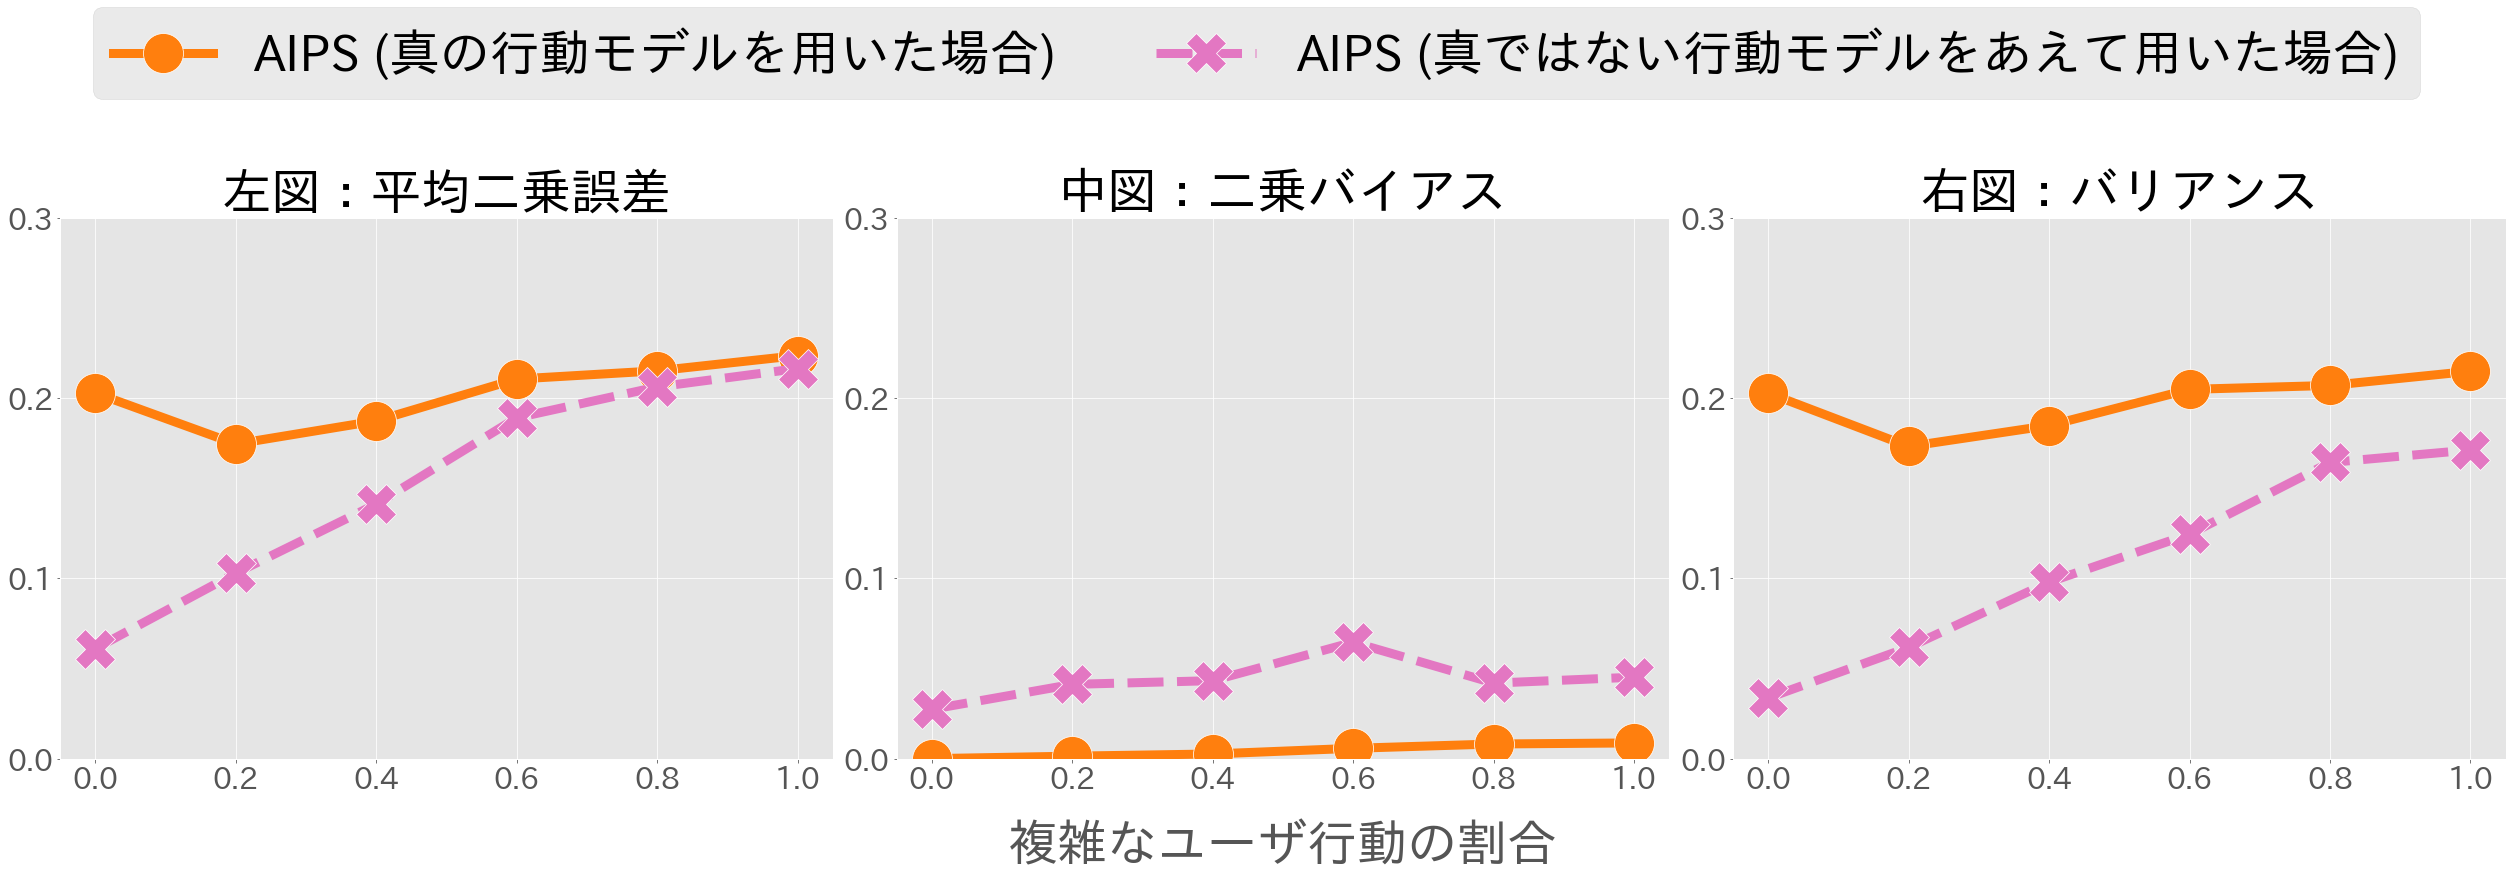

In [10]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="p_rand",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:orange", "tab:pink"],
        data=result_df_rand.query("est == 'aips' or est == 'aips (tune)'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.30)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"複雑なユーザ行動の割合", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(p_rand_list)
    ax.set_xticklabels(p_rand_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["AIPS (真の行動モデルを用いた場合)", "AIPS (真ではない行動モデルをあえて用いた場合)"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)
